In [125]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import ast
import math
import joypy
import seaborn as sns

#### Load data

In [189]:
df = pd.read_csv('comparison.csv')

#### Clean data

In [190]:
def string_to_numpy_array(s):
    # Evaluate the string in a restricted namespace
    parsed = eval(s, {"array": np.array})
    # Stack arrays into a 2D numpy array
    return np.vstack(parsed)

def clean_data(df):
    matrices = [col for col in df.columns if 'matrix' in col]
    for matrix in matrices: 
        if isinstance(df[matrix].iloc[1], str):
            df[matrix] = df[matrix].apply(string_to_numpy_array)

In [191]:
clean_data(df)

In [192]:
# If separated by space
# df['reliability'] = df['reliability'].apply(lambda x: np.round(np.fromstring(x.strip("[]"), sep=" "), 2))

# If separated by commas
df['reliability'] = df['reliability'].apply(ast.literal_eval)

#### Plot main connections

In [29]:
def create_network(row, matrix, threshold=0):
    """threshold: below the threshold, do not display edge"""
    G = nx.DiGraph()
    G.add_node('nature')
    n = len(row['reliability'])
    for i in range(n):
        G.add_node(i)
        urn = row[matrix][i]
        if urn[0]/sum(urn) > threshold:
            G.add_edge(i, "nature", weight=urn[0]/sum(urn))
        for j in range(n):
            if (i != j) and (urn[j+1]/sum(urn) > threshold):
                G.add_edge(i, j, weight=urn[j+1]/sum(urn))
    return G

In [35]:
def draw_network(G, Rs):
    
    # Create a directed graph with significant edges (above threshold prob)
    n = len(G.nodes) - 1
    # Get the weights for the edges
    weights = nx.get_edge_attributes(G, 'weight')

    # Normalize weights for better visualization
    max_weight = max(weights.values(), default=1)
    edge_widths = [(weight * 2) / max_weight for weight in weights.values()]
    
    # Draw the network
    # Label with reliability
    labels = {key: value for key, value in zip(range(n), Rs)}
    labels['nature'] = 'nature'
    
    pos = nx.shell_layout(G, nlist=[list(labels.keys())])
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=1500, 
            arrows=True, arrowstyle='-|>', arrowsize=20, edge_color='black', 
            width=edge_widths, edgecolors='black')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    # Label edges
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}

    for (u, v), label in edge_labels.items():
        # Compute midpoint
        x_start, y_start = pos[u]
        x_end, y_end = pos[v]
        # Offset to position label closer to the start of the edge
        offset = 0.6  # Adjust this value to control the distance from the start
        x_label = x_start + offset * (x_end - x_start)
        y_label = y_start + offset * (y_end - y_start)
        
        # Draw the label
        plt.text(x_label, y_label, label, color='black', fontsize=7, 
                 ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))


In [80]:
"""randomly select a run"""
x = random.randint(0, len(df)-1)
print(x)
row = df.iloc[x]

65


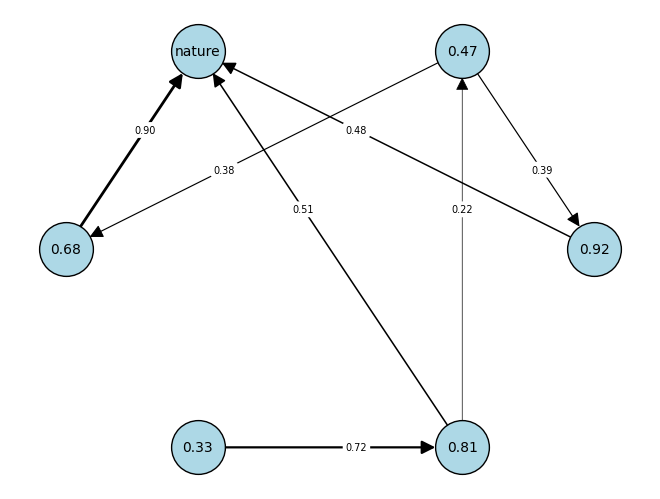

In [81]:
G = create_network(row, 'matrix_CompWeight_F', threshold=0.2)
draw_network(G, row.reliability)
# plt.savefig('graphs/coop_weight_network.png', bbox_inches='tight')

#### Plot correlations

In [193]:
def corr_df(matrix, df):
    """matrix: column name for the urn matrix"""
    """returns a df with columns: reliability, nature, followed"""
    """nature: the proportion of time that the agent consults nature"""
    """followed: the proportion of time an agent is consulted by others"""
    columns = ['run', 'reliability', 'nature', 'followed']
    corr = pd.DataFrame(columns = columns)
    for index, row in df.iterrows():
        for i in range(len(row['reliability'])): 
            temp = {'run': index}
            temp['reliability'] = row['reliability'][i]
            if 'flex' in matrix:
                temp['nature'] = row[matrix][i][0]
                temp['followed'] = round(sum([subrow[i+1] for subrow in row[matrix]])/(len(matrix) - 1), 2)
            else:
                temp['nature'] = row[matrix][i][0]/sum(row[matrix][i])
                prob_consultation = [subrow[i+1] / sum(subrow) for subrow in row[matrix]]
                temp['followed'] = round(sum(prob_consultation)/(len(prob_consultation) - 1), 2)
            corr = pd.concat([corr, pd.DataFrame([temp])], ignore_index=True)
    return corr

In [198]:
corr = corr_df('matrix_CompWeight_F', df)

##### Plot Relationship: Reliability-Nature

Text(0.5, 1.0, '')

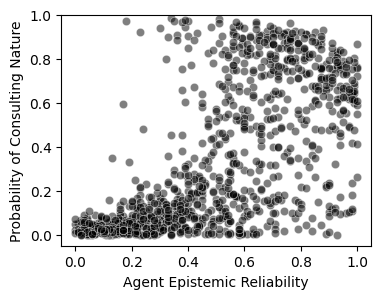

In [199]:
plt.figure(figsize=(4, 3))
plt.scatter(corr['reliability'], corr['nature'], alpha=0.5, c='black', edgecolors='w', linewidth=0.5)
plt.ylim(-0.05, 1)
plt.xlabel('Agent Epistemic Reliability')
plt.ylabel('Probability of Consulting Nature')
plt.title('')
# plt.savefig('graphs/nature_individual.png', bbox_inches='tight')

##### Plot Relationship: Reliability-Followed

Text(0.5, 1.0, '')

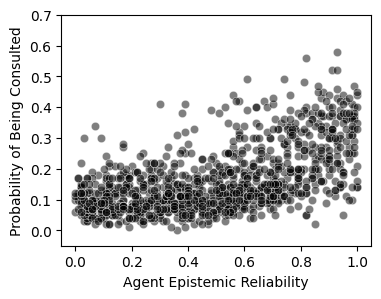

In [200]:
plt.figure(figsize=(4, 3))
plt.scatter(corr['reliability'], corr['followed'], alpha=0.5, c='black', edgecolors='w', linewidth=0.5)
plt.ylim(-0.05, 0.7)
plt.xlabel('Agent Epistemic Reliability')
plt.ylabel('Probability of Being Consulted')
plt.title('')
# plt.savefig('graphs/influence_comp.png', bbox_inches='tight')

#### Compare success rate

In [86]:
def majority_vote(p):
    """compute the probability of success if all agents only consult nature and take a majority vote"""
    n = len(p)
    half_n = n // 2
    
    # Create a DP table where dp[i][j] is the probability of getting j heads with the first i coins
    dp = np.zeros((n + 1, n + 1))
    dp[0][0] = 1  # Base case: 0 coins, 0 heads has probability 1
    
    for i in range(1, n + 1):
        for j in range(i + 1):
            # If the i-th coin is tails
            dp[i][j] += dp[i - 1][j] * (1 - p[i - 1])
            # If the i-th coin is heads
            if j > 0:
                dp[i][j] += dp[i - 1][j - 1] * p[i - 1]
    
    # Calculate the total probability of getting more than half heads
    probability = sum(dp[n][j] for j in range(half_n + 1, n + 1))
    return probability

def success_percentage(data):
    return [int(x)/20000 for x in data]

def take_avg(data):
    return sum(data)/len(data)

def get_top(row, col):
    max_index = row['reliability'].index(max(row['reliability']))  # Get index of max
    return row[col][max_index]  # Return corresponding entry

In [87]:
def success_rates(df, success_col):
    """success_col: list of columns names containing success data to be compared"""
    success_df = pd.DataFrame()  
    avg_col = [c+'_avg' for c in success_col]
    max_col = [c+'_max' for c in success_col]
    min_col = [c+'_min' for c in success_col]
    
    for c in success_col:
        success_df[c] = df[c].apply(ast.literal_eval).apply(success_percentage)
        success_df[c+'_avg'] = success_df[c].apply(take_avg)
        success_df[c+'_max'] = success_df[c].apply(max)
        success_df[c+'_min'] = success_df[c].apply(min)
    
    if 'reliability' in df.columns:
        success_df['reliability'] = df['reliability'] 
        top_ceiling = [c+'_top-ceiling' for c in success_col]
        avg_ceiling = [c+'_avg-ceiling' for c in success_col]
        for c in success_col:
            success_df[c+'_top-ceiling'] = success_df.apply(get_top, axis=1, args=(c,)) - success_df['reliability'].apply(max)
            success_df[c+'_avg-ceiling'] = success_df[c].apply(take_avg) - success_df['reliability'].apply(max)
    return success_df

In [88]:
success_col = ['success_BSM', 
               'success_BH', 
               'success_CoopWeight_F',
               'success_CompWeight_F']

success_df = success_rates(df, success_col)

Text(0.5, 1.0, 'Success Rate')

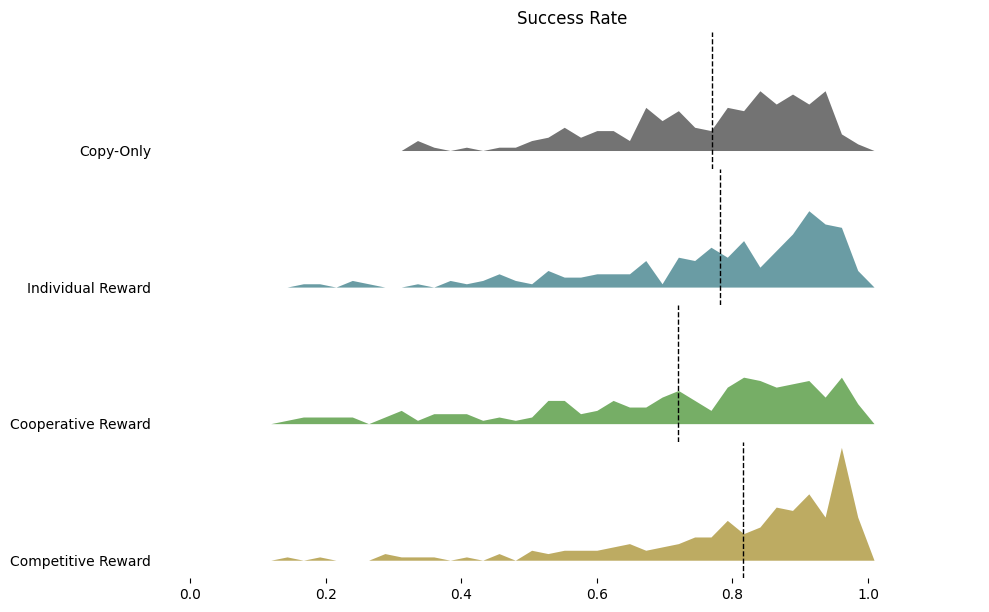

In [89]:
labels = ['Copy-Only', 'Individual Reward', 'Cooperative Reward', 'Competitive Reward']
temp = success_df[[c+'_avg' for c in success_col]]
temp.columns = labels
fig, axes = joypy.joyplot(
    temp,
    overlap=0,
    colormap=plt.cm.gist_earth,
    ylabels=labels,
    figsize=(10,6), 
    fade=True, 
    alpha=0.7, 
    linewidth=0,
    kind='counts',
    bins=50,
)

for i, col in enumerate(labels):
    mean = temp[col].mean()
    axes[i].axvline(mean, color='black', linestyle='--', linewidth=1, zorder=10)
    
plt.title('Success Rate')
# plt.savefig('graphs/avg.png', bbox_inches='tight')

Text(0.5, 1.0, 'Top Agent Success Rate - Reliability')

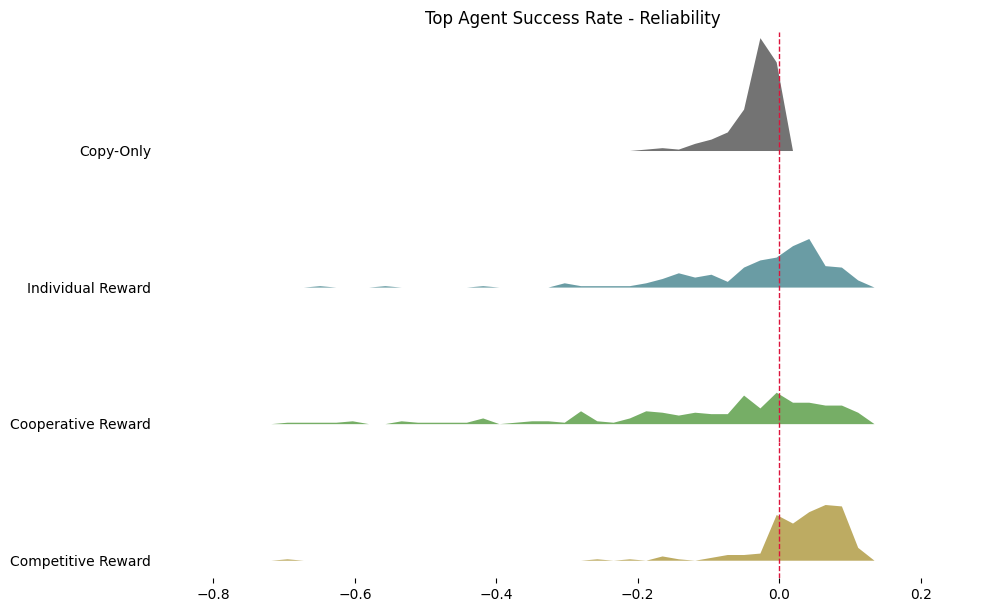

In [91]:
labels = ['Copy-Only', 'Individual Reward', 'Cooperative Reward', 'Competitive Reward']
temp = success_df[[c+'_top-ceiling' for c in success_col]]
temp.columns = labels
fig, axes = joypy.joyplot(
    temp,
    overlap=0,
    colormap=plt.cm.gist_earth,
    ylabels=labels,
    figsize=(10,6), 
    fade=True, 
    alpha=0.7, 
    linewidth=0,
    kind='counts',
    bins=50,
)

for i, col in enumerate(labels):
    axes[i].axvline(0, color='crimson', linestyle='--', linewidth=1, zorder=10)
    
plt.title('Top Agent Success Rate - Reliability')
# plt.savefig('graphs/top-ceiling.png', bbox_inches='tight')

Text(0.5, 1.0, 'Average Success Rate - Reliability')

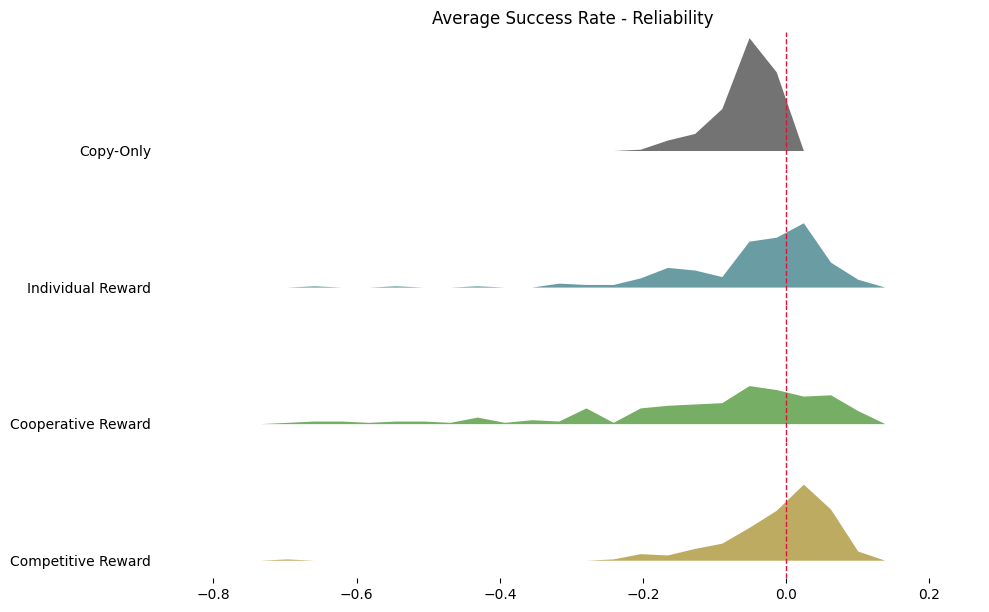

In [93]:
labels = ['Copy-Only', 'Individual Reward', 'Cooperative Reward', 'Competitive Reward']
temp = success_df[[c+'_avg-ceiling' for c in success_col]]
temp.columns = labels
fig, axes = joypy.joyplot(
    temp,
    overlap=0,
    colormap=plt.cm.gist_earth,
    ylabels=labels,
    figsize=(10,6), 
    fade=True, 
    alpha=0.7, 
    linewidth=0,
    kind='counts',
    bins=30,
)

for i, col in enumerate(labels):
    axes[i].axvline(0, color='crimson', linestyle='--', linewidth=1, zorder=10)
    
plt.title('Average Success Rate - Reliability')
# plt.savefig('graphs/avg-ceiling.png', bbox_inches='tight')

#### Appendix - Bonus¶

In [95]:
success_col = ['success_CoopWeight_F', 
               'success_CoopBonus_F', 
               'success_CompWeight_F',
               'success_CompBonus_F']
success_df = success_rates(df, success_col)

Text(0.5, 1.0, 'Success Rate')

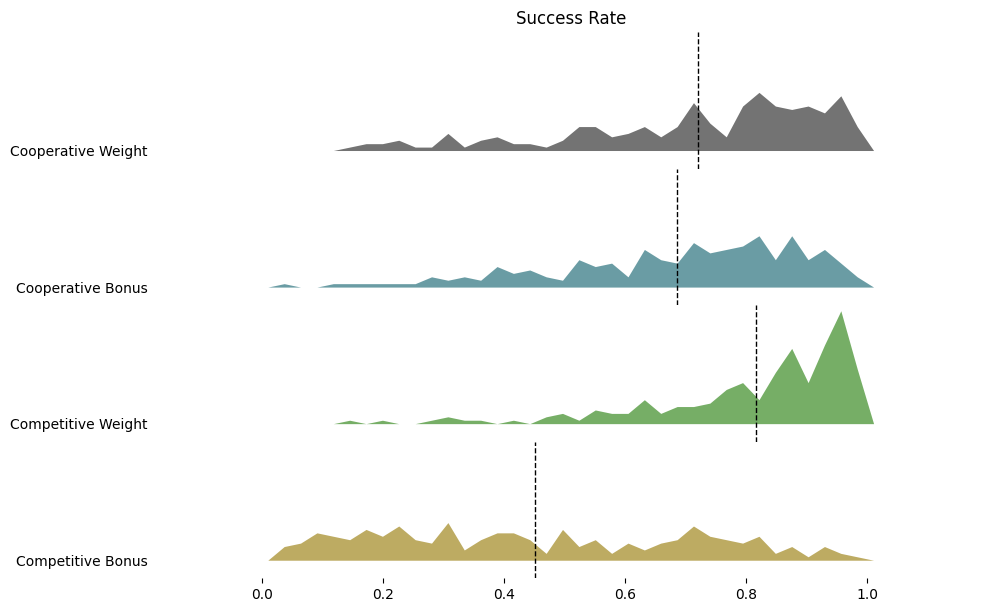

In [96]:
labels = ['Cooperative Weight', 'Cooperative Bonus', 'Competitive Weight', 'Competitive Bonus']
temp = success_df[[c+'_avg' for c in success_col]]
temp.columns = labels
fig, axes = joypy.joyplot(
    temp,
    overlap=0,
    colormap=plt.cm.gist_earth,
    ylabels=labels,
    figsize=(10,6), 
    fade=True, 
    alpha=0.7, 
    linewidth=0,
    kind='counts',
    bins=50,
)

for i, col in enumerate(labels):
    mean = temp[col].mean()
    axes[i].axvline(mean, color='black', linestyle='--', linewidth=1, zorder=10)
    
plt.title('Success Rate')
# plt.savefig('graphs/bonus.png', bbox_inches='tight')

#### Appendix - Baseline

In [98]:
baseline = pd.read_csv('baseline.csv')
s_cols = ['success_BH', 'success_CoopWeight_F', 'success_CompWeight_F']
m_cols = ['matrix_BH', 'matrix_CoopWeight_F', 'matrix_CompWeight_F']
clean_data(baseline)
# for c in s_cols:
#     baseline[c] = baseline[c].apply(ast.literal_eval)

In [99]:
baseline_success = success_rates(baseline, s_cols)

Text(0, 0.5, 'Success Rate')

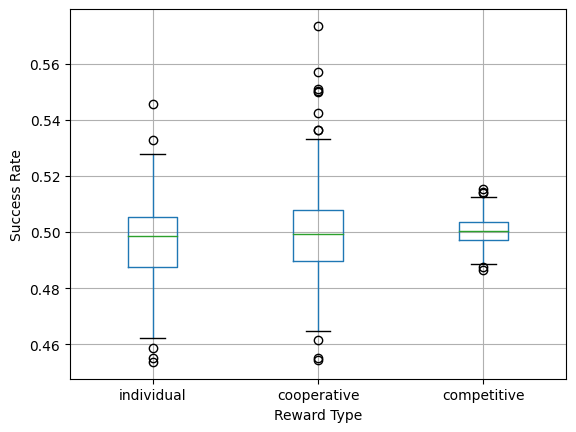

In [100]:
ax = baseline_success.boxplot(column=[c+'_avg' for c in s_cols])
ax.set_xticklabels(['individual', 'cooperative', 'competitive'])
plt.xlabel('Reward Type')
plt.ylabel('Success Rate')

In [101]:
columns = ['nature', 'followed']
strategy = pd.DataFrame(columns = [c+'_nature' for c in m_cols] + [c+'_followed' for c in m_cols])

for c in s_cols:
    baseline[c] = baseline[c].apply(ast.literal_eval)

for index, row in baseline.iterrows():
    for i in range(len(row['success_BH'])):
        temp = {}
        for matrix in m_cols:
            temp[matrix+'_nature'] = row[matrix][i][0]/sum(row[matrix][i])
            prob_consultation = [subrow[i+1] / sum(subrow) for subrow in row[matrix]]
            temp[matrix+'_followed'] = round(sum(prob_consultation)/(len(prob_consultation) - 1), 2)
        strategy = pd.concat([strategy, pd.DataFrame([temp])], ignore_index=True)

In [102]:
# ax = strategy.boxplot(column=[c+'_nature' for c in m_cols])
# ax.set_xticklabels(['individual', 'cooperative', 'competitive'])
# plt.xlabel('Reward Type')
# plt.ylabel('Rate of consulting nature')
# ax.set_ylim(0, 1)

Text(0.5, 1.0, 'Rate of consulting nature')

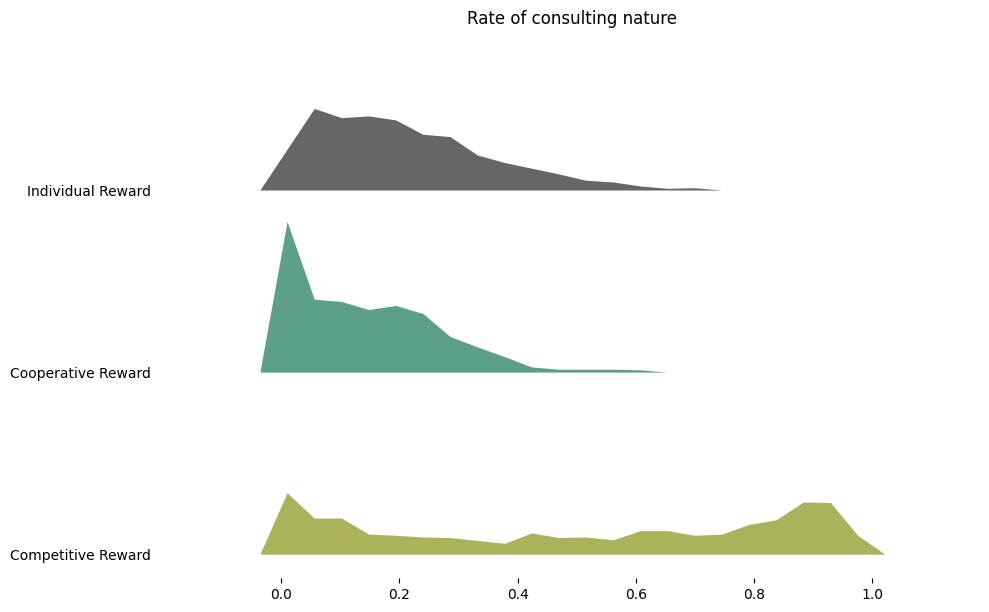

In [103]:
labels = ['Individual Reward', 'Cooperative Reward', 'Competitive Reward']
temp = strategy[[c+'_nature' for c in m_cols]]
temp.columns = labels
fig, axes = joypy.joyplot(
    temp,
    overlap=0,
    colormap=plt.cm.gist_earth,
    ylabels=labels,
    figsize=(10,6), 
    fade=True, 
    alpha=0.7, 
    linewidth=0,
    kind='counts',
    bins=30,
)
    
plt.title('Rate of consulting nature')
# plt.savefig('graphs/baseline.png', bbox_inches='tight')

(0.0, 1.0)

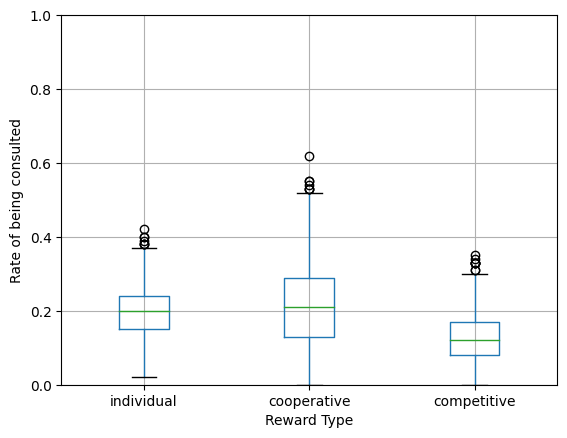

In [104]:
ax = strategy.boxplot(column=[c+'_followed' for c in m_cols])
ax.set_xticklabels(['individual', 'cooperative', 'competitive'])
plt.xlabel('Reward Type')
plt.ylabel('Rate of being consulted')
ax.set_ylim(0, 1)

### Two Urn Model

In [203]:
df = pd.read_csv('test.csv')

In [204]:
clean_data(df)

In [205]:
df['reliability'] = df['reliability'].apply(lambda x: np.round(np.fromstring(x.strip("[]"), sep=" "), 2))
df['success'] = df['success'].apply(ast.literal_eval)

"""Measure standard deviation in the quantity urns, averaged across agents."""
"""Higher means stable strategy. 0 means failed to learn."""
df['Q_sd'] = df['Q_matrix'].apply(lambda arr: np.round(np.std(arr, axis=1), 2).tolist())
df['Q_sd'] = df['Q_sd'].apply(lambda arr: np.round(np.mean(arr), 2))

df['cp_ratio'] = df['cost'] / df['payoff'] # Cost to payoff ratio
df['mean_success'] = df['success'].apply(lambda arr: np.round(np.mean(arr), 2)/20000) # Mean success rate

In [223]:
df['mean_success'].describe()

count    24300.000000
mean         0.670588
std          0.170574
min          0.020338
25%          0.568561
50%          0.686753
75%          0.796050
max          0.999400
Name: mean_success, dtype: float64

In [206]:
for n in df['n'].unique():
    print('number of agents: ', n)
    print('Pearson correlation between cost/payoff and Q-urn SD: ', 
          df[df['n']==n][['cp_ratio', 'Q_sd']].corr().iloc[0, 1])
    print()

number of agents:  5
Pearson correlation between cost/payoff and Q-urn SD:  -0.5093744367939715

number of agents:  8
Pearson correlation between cost/payoff and Q-urn SD:  -0.48094310739941176

number of agents:  12
Pearson correlation between cost/payoff and Q-urn SD:  -0.4636749985621699



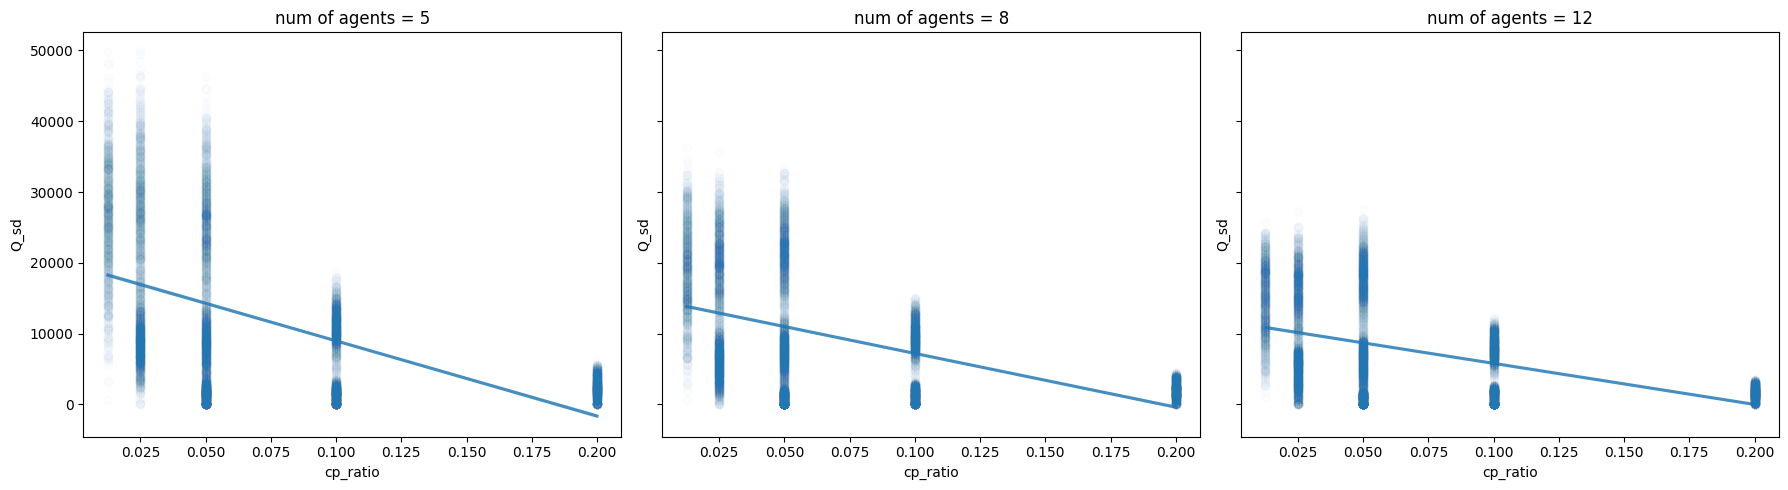

In [209]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

n_values = [5, 8, 12]
for i, n_val in enumerate(df['n'].unique()):
    subset = df[df['n'] == n_val]
    sns.regplot(x='cp_ratio', y='Q_sd', data=subset,
                scatter_kws={'alpha': 0.01}, line_kws={'alpha': 0.8}, ax=axes[i])
    axes[i].set_title(f'num of agents = {n_val}')

plt.tight_layout()

In [208]:
for n in df['n'].unique():
    print('number of agents: ', n)
    print('Pearson correlation between cost/payoff and success rate: ', 
          df[df['n']==n][['cp_ratio', 'mean_success']].corr().iloc[0, 1])
    print()

number of agents:  5
Pearson correlation between cost/payoff and success rate:  -0.009866592322181043

number of agents:  8
Pearson correlation between cost/payoff and success rate:  0.02440844921606256

number of agents:  12
Pearson correlation between cost/payoff and success rate:  0.017318543662017013



In [232]:
"""Generate a df with reliability, prob for consulting nature, prob for being consulted"""
corr = corr_df('matrix', df[((df['n']==5) & (df['cp_ratio']==0.1)) & 
               ((df['min_R']==0) & (df['max_R']==1))])

Text(0.5, 1.0, '')

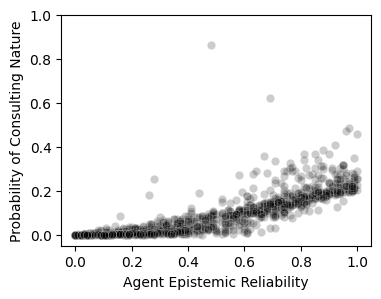

In [233]:
plt.figure(figsize=(4, 3))
plt.scatter(corr['reliability'], corr['nature'], alpha=0.2, c='black', edgecolors='w', linewidth=0.5)
plt.ylim(-0.05, 1)
plt.xlabel('Agent Epistemic Reliability')
plt.ylabel('Probability of Consulting Nature')
plt.title('')

Text(0.5, 1.0, '')

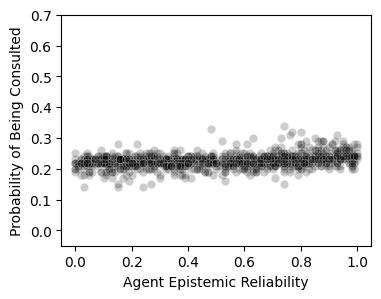

In [234]:
plt.figure(figsize=(4, 3))
plt.scatter(corr['reliability'], corr['followed'], alpha=0.2, c='black', edgecolors='w', linewidth=0.5)
plt.ylim(-0.05, 0.7)
plt.xlabel('Agent Epistemic Reliability')
plt.ylabel('Probability of Being Consulted')
plt.title('')